In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings

# --- Sklearn Imports (for Preprocessing, Splitting, and Metrics) ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.exceptions import ConvergenceWarning

# --- For 3D Plotting ---
from mpl_toolkits.mplot3d import Axes3D

# --- For Progress Bars ---
from tqdm.notebook import tqdm

# --- Suppress Warnings ---
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# --- Matplotlib Setup ---
%matplotlib inline
sns.set(style="whitegrid", palette="deep")

print("All libraries imported successfully.")

All libraries imported successfully.


In [32]:
# --- Configuration ---
# ❗ **ACTION REQUIRED**: Update this to the FULL, ABSOLUTE path to your code folder.
# Example: CLASSIFIER_DIR = r'C:\Users\jaink\OneDrive\Desktop\ML_Project\Classifier_codes'
CLASSIFIER_DIR = r'C:\Users\jaink\OneDrive\Desktop\ML_Project\Classifier_codes'
# ---------------------

if not os.path.isdir(CLASSIFIER_DIR):
    print(f"Error: Classifier directory '{CLASSIFIER_DIR}' not found.")
    print("Please update the path in this cell.")
else:
    # Add the folder to the system path to allow imports
    if CLASSIFIER_DIR not in sys.path:
        sys.path.append(os.path.abspath(CLASSIFIER_DIR))
    
    try:
        # Import all 9 of your classifier classes
        from KNN import KNN
        from LogisticRegression import LogisticRegression
        from DecisionTree import DecisionTreeClassifier # Assumes Node class is in this file
        from RandomForest import RandomForestClassifier # Assumes this imports DecisionTree
        from SVM import LinearSVM
        from GaussianNaiveBayes import GaussianNaiveBayes
        from MultiLayerPerceptron import SimpleMLP
        from LinearDiscriminantAnalysis import LDA
        from AdaBoost import AdaBoost # Assumes DecisionStump is in this file
        
        print("✅ Successfully imported all 9 from-scratch classifiers.")
    except ImportError as e:
        print(f"--- 🛑 IMPORT ERROR ---")
        print(f"Error importing classifiers: {e}")
        print("Please check file/class names in your 'Classifier_codes' folder.")
    except Exception as e:
        print(f"An unexpected error occurred during import: {e}")

✅ Successfully imported all 9 from-scratch classifiers.


In [3]:
# This helper class is essential for this multi-class dataset.
# It allows your binary-only models (LogReg, SVM, MLP, AdaBoost) to work.

class OvRWrapper:
    """Wraps a binary classifier to support multi-class OvR classification."""
    def __init__(self, binary_classifier_class, **kwargs):
        self.binary_classifier_class = binary_classifier_class
        self.kwargs = kwargs
        self.models = {}
        self.classes_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)

        # This logic is robust: it handles both binary and multi-class cases
        if n_classes <= 2:
            le = LabelEncoder()
            y_binary = le.fit_transform(y)
            model = self.binary_classifier_class(**self.kwargs)
            model.fit(X, y_binary)
            self.models[le.classes_[1]] = model 
            self.binary_le = le
        else:
            # Multi-class OvR problem
            self.binary_le = None
            for cls in self.classes_:
                y_train_binary = np.where(y == cls, 1, 0)
                model = self.binary_classifier_class(**self.kwargs)
                model.fit(X, y_train_binary)
                self.models[cls] = model
    
    def predict(self, X):
        if self.binary_le:
             # Binary case
             model_key = list(self.models.keys())[0]
             binary_preds = self.models[model_key].predict(X)
             return self.binary_le.inverse_transform(binary_preds)
        else:
            # Multi-class OvR case
            all_scores = []
            for cls in self.classes_:
                model = self.models[cls]
                # Get the best possible score from the binary model
                if hasattr(model, 'predict_proba'):
                    probas = model.predict_proba(X)
                    all_scores.append(probas[:, 1] if probas.ndim == 2 and probas.shape[1] == 2 else probas)
                elif hasattr(model, 'decision_function'):
                    all_scores.append(model.decision_function(X))
                else:
                    all_scores.append(model.predict(X))
            
            scores_matrix = np.stack(all_scores, axis=1)
            best_class_indices = np.argmax(scores_matrix, axis=1)
            return self.classes_[best_class_indices]

print("OvRWrapper class defined.")

OvRWrapper class defined.


In [4]:
# ❗ **ACTION REQUIRED**: Update this path to your CSV file.
# e.g., r'C:\Users\jaink\OneDrive\Desktop\ML_Project\data\maternal_health.csv'
DATA_PATH = r'C:\Users\jaink\OneDrive\Desktop\ML_Project\MentalHealth\Maternal Health Risk Data Set.csv'

if not os.path.exists(DATA_PATH):
    print(f"Error: Data file not found at {DATA_PATH}")
    print("Please update the 'DATA_PATH' variable in this cell.")
else:
    df = pd.read_csv(DATA_PATH)
    print(f"Dataset loaded successfully. Shape: {df.shape}")

Dataset loaded successfully. Shape: (1014, 7)


In [5]:
print("--- Data Info ---")
df.info()
print("\n--- Missing Values ---")
print(df.isnull().sum())

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB

--- Missing Values ---
Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64


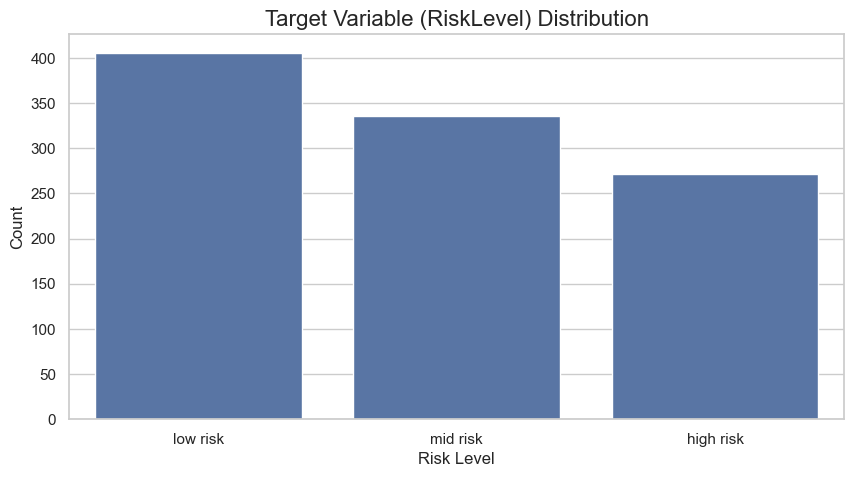

In [6]:
# --- Target Variable: RiskLevel ---
plt.figure(figsize=(10, 5))
sns.countplot(x='RiskLevel', data=df, order=df['RiskLevel'].value_counts().index)
plt.title('Target Variable (RiskLevel) Distribution', fontsize=16)
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.show()

Generating Pair Plot... (This may take a moment)


<Figure size 2000x2000 with 0 Axes>

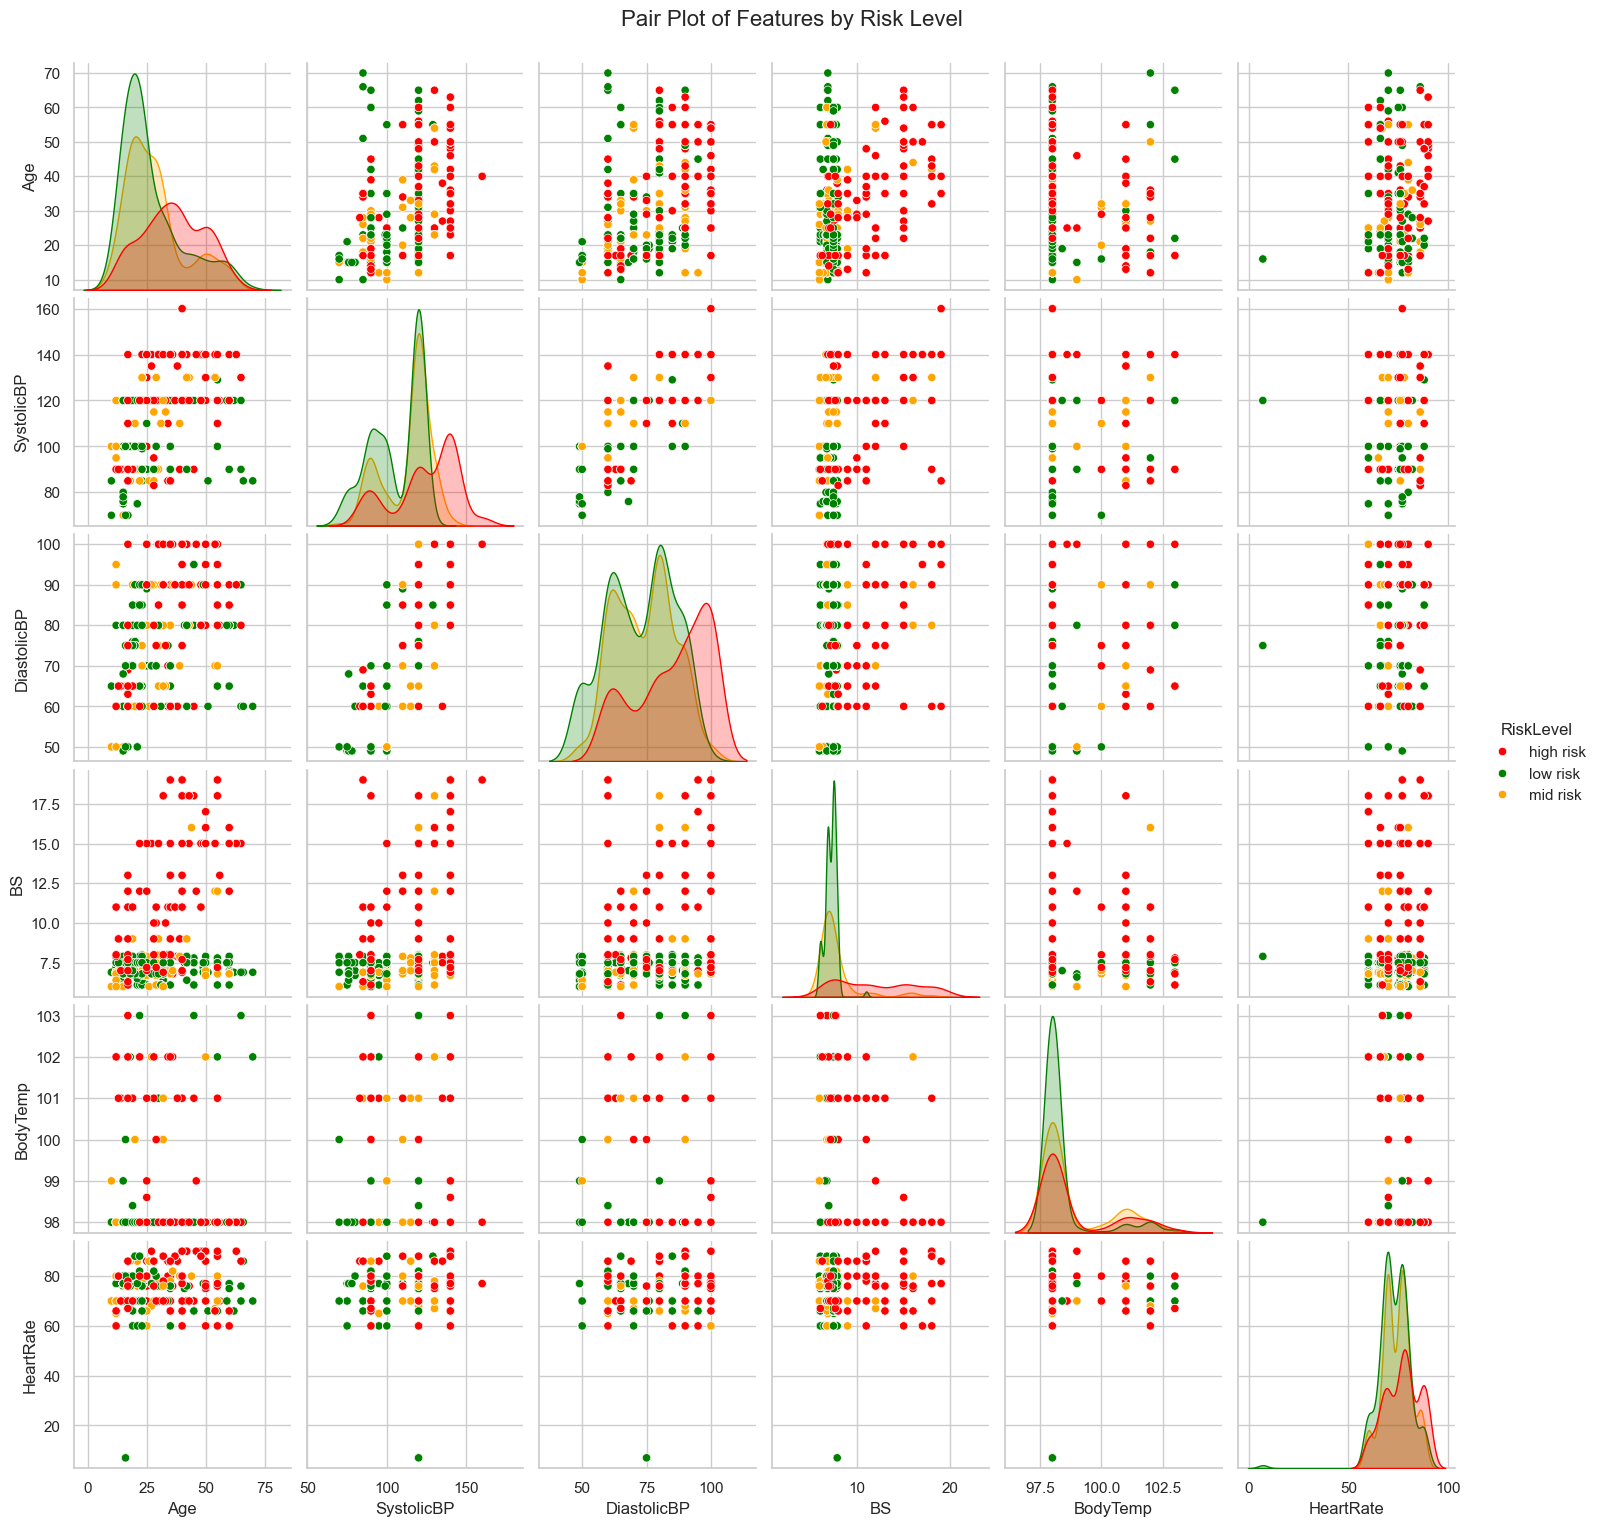

In [7]:
# --- Pair Plot of All Features by RiskLevel ---
# This is the single most powerful EDA plot for this dataset.
print("Generating Pair Plot... (This may take a moment)")
plt.figure(figsize=(20, 20))
sns.pairplot(df, hue='RiskLevel', palette={'low risk': 'green', 'mid risk': 'orange', 'high risk': 'red'})
plt.suptitle('Pair Plot of Features by Risk Level', y=1.02, fontsize=16)
plt.show()

C:\Users\jaink\AppData\Local\Temp\ipykernel_1436\2968489005.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_corr.corr()


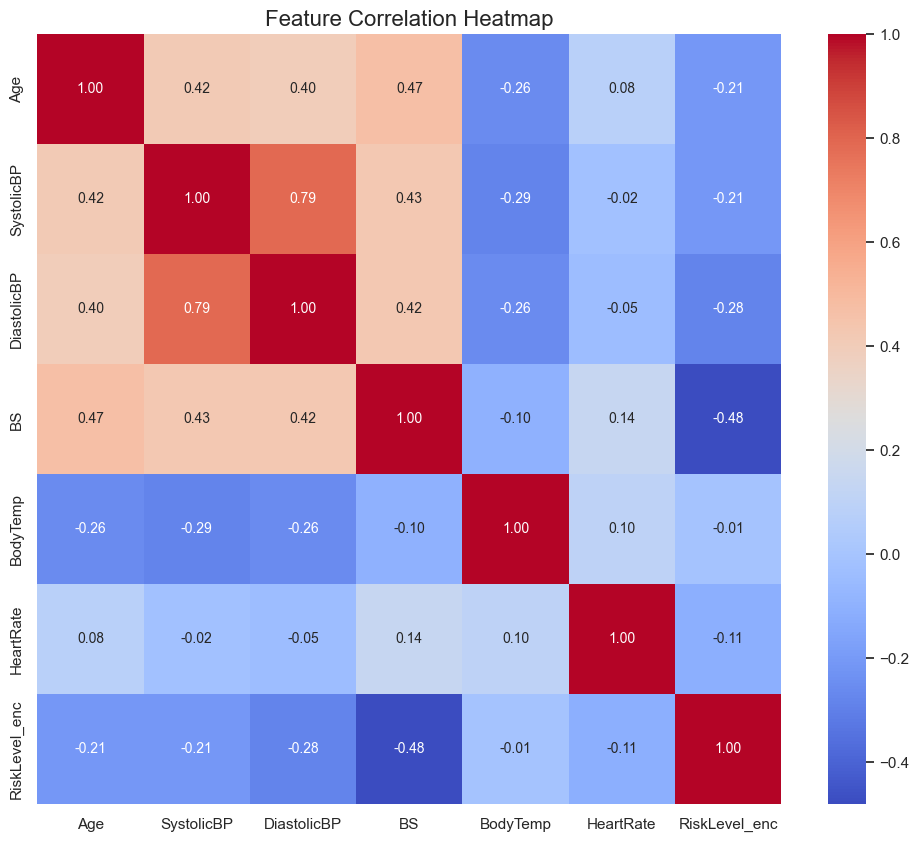

In [8]:
# --- Correlation Heatmap ---
# We'll copy the df and encode the target for this plot
df_corr = df.copy()
df_corr['RiskLevel_enc'] = LabelEncoder().fit_transform(df['RiskLevel'])

plt.figure(figsize=(12, 10))
correlation_matrix = df_corr.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 10})
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.show()

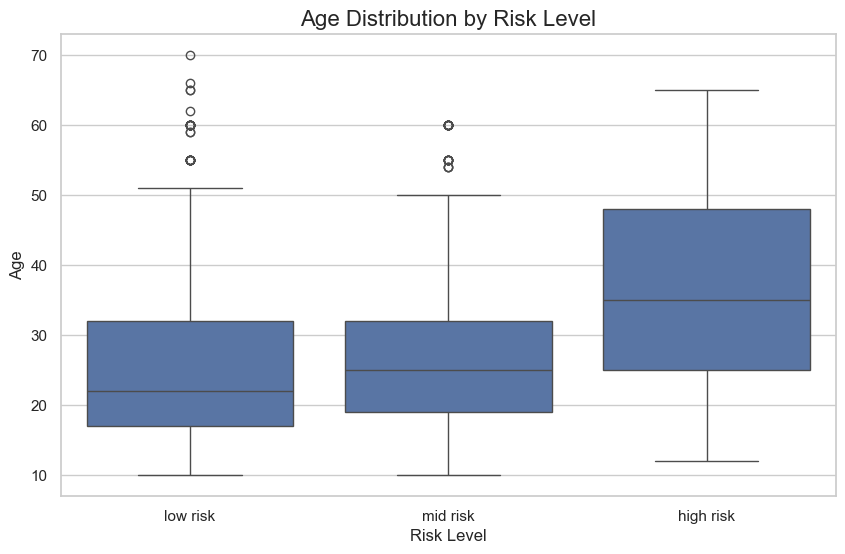

In [9]:
# --- Box Plot: Age vs. RiskLevel ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='RiskLevel', y='Age', order=['low risk', 'mid risk', 'high risk'])
plt.title('Age Distribution by Risk Level', fontsize=16)
plt.xlabel('Risk Level')
plt.ylabel('Age')
plt.show()

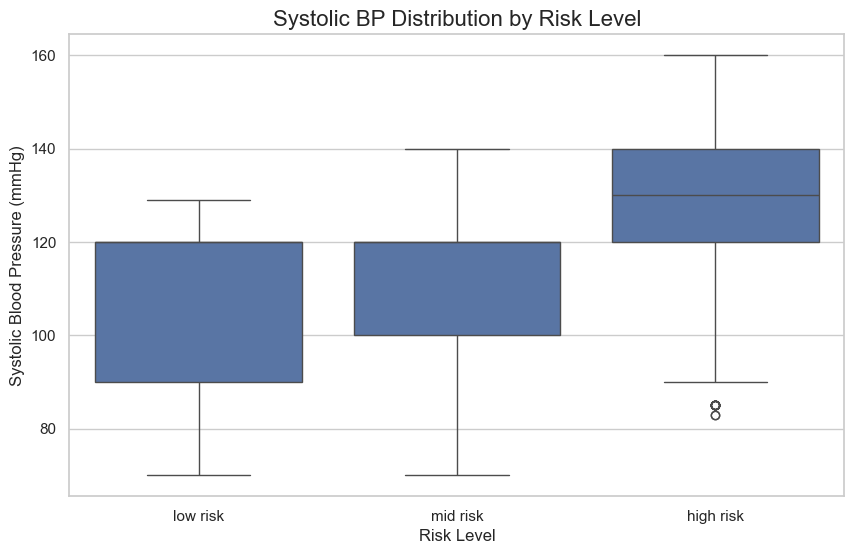

In [10]:
# --- Box Plot: SystolicBP vs. RiskLevel ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='RiskLevel', y='SystolicBP', order=['low risk', 'mid risk', 'high risk'])
plt.title('Systolic BP Distribution by Risk Level', fontsize=16)
plt.xlabel('Risk Level')
plt.ylabel('Systolic Blood Pressure (mmHg)')
plt.show()

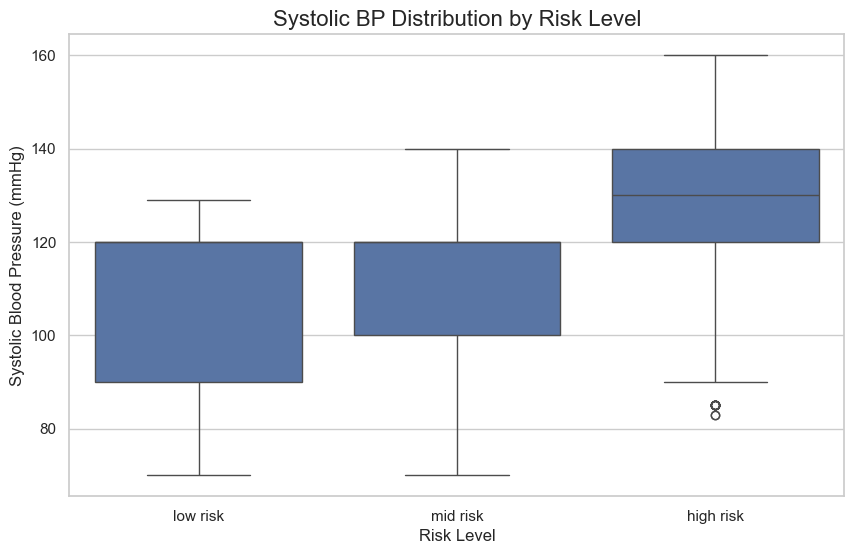

In [11]:
# --- Box Plot: SystolicBP vs. RiskLevel ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='RiskLevel', y='SystolicBP', order=['low risk', 'mid risk', 'high risk'])
plt.title('Systolic BP Distribution by Risk Level', fontsize=16)
plt.xlabel('Risk Level')
plt.ylabel('Systolic Blood Pressure (mmHg)')
plt.show()

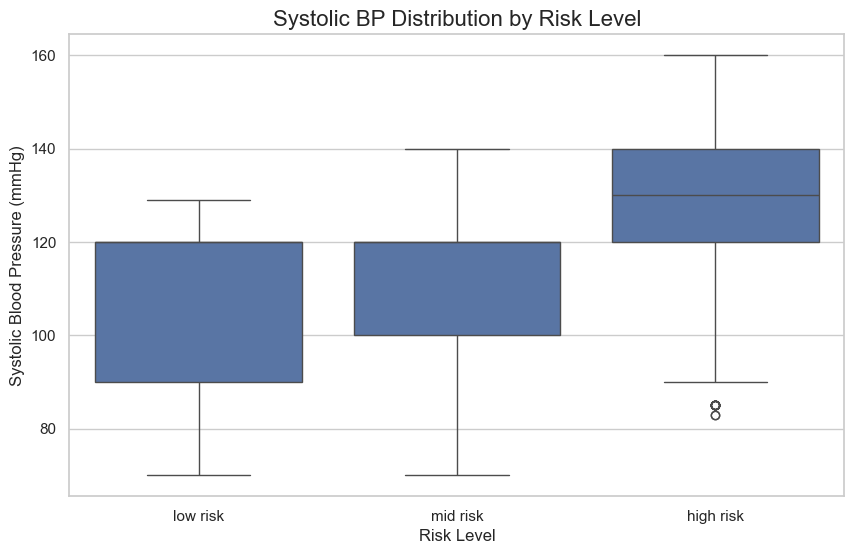

In [12]:
# --- Box Plot: SystolicBP vs. RiskLevel ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='RiskLevel', y='SystolicBP', order=['low risk', 'mid risk', 'high risk'])
plt.title('Systolic BP Distribution by Risk Level', fontsize=16)
plt.xlabel('Risk Level')
plt.ylabel('Systolic Blood Pressure (mmHg)')
plt.show()

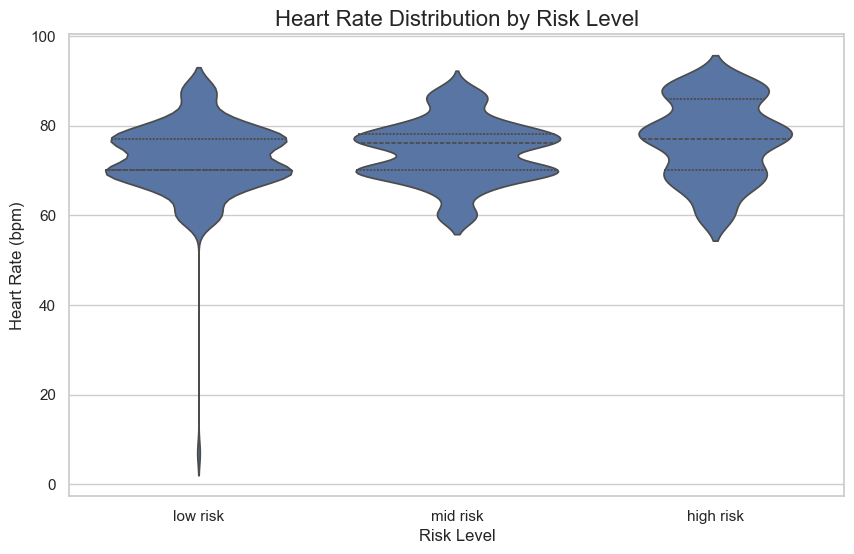

In [13]:
# --- Violin Plot: HeartRate vs. RiskLevel ---
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='RiskLevel', y='HeartRate', order=['low risk', 'mid risk', 'high risk'], inner='quartile')
plt.title('Heart Rate Distribution by Risk Level', fontsize=16)
plt.xlabel('Risk Level')
plt.ylabel('Heart Rate (bpm)')
plt.show()

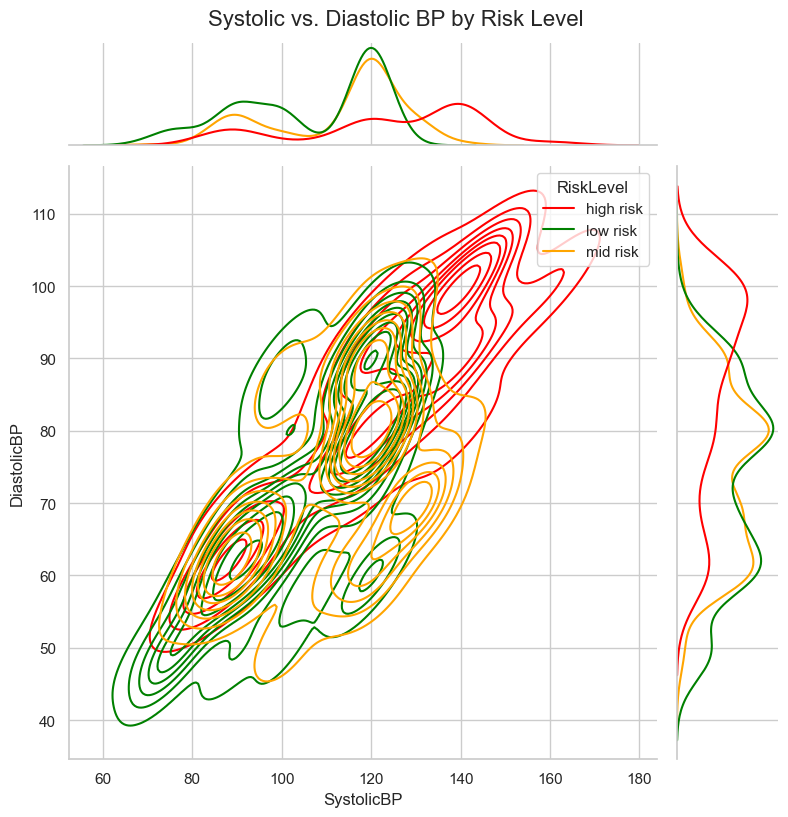

In [14]:
# --- 2D Density Plot: SystolicBP vs. DiastolicBP ---
g = sns.jointplot(
    data=df,
    x="SystolicBP",
    y="DiastolicBP",
    hue="RiskLevel",
    kind="kde",
    height=8,
    palette={'low risk': 'green', 'mid risk': 'orange', 'high risk': 'red'}
)
g.fig.suptitle('Systolic vs. Diastolic BP by Risk Level', y=1.02, fontsize=16)
plt.show()

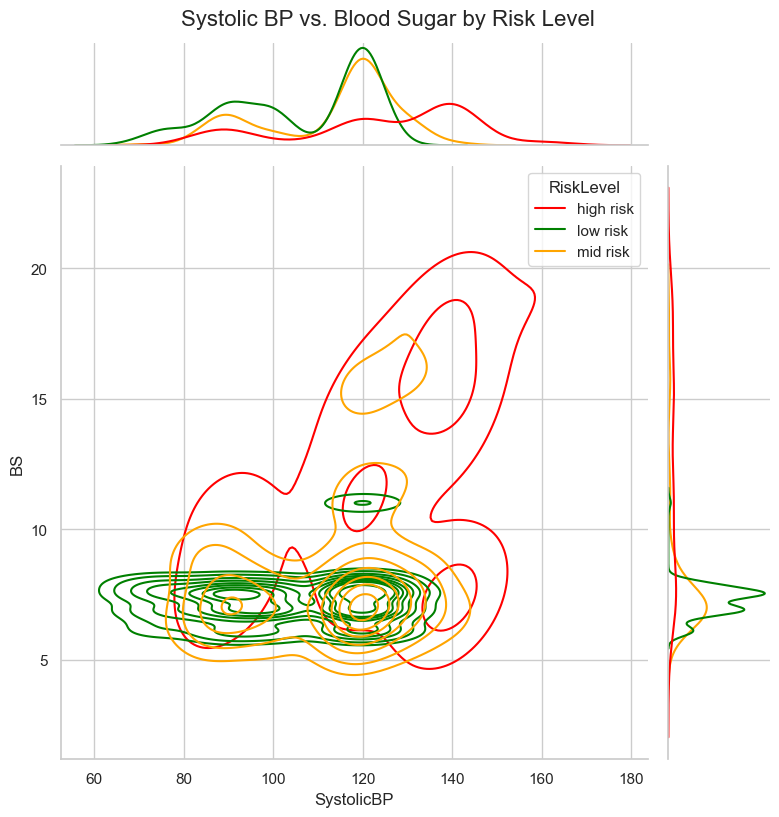

In [15]:
# --- 2D Density Plot: SystolicBP vs. BS ---
g = sns.jointplot(
    data=df,
    x="SystolicBP",
    y="BS",
    hue="RiskLevel",
    kind="kde",
    height=8,
    palette={'low risk': 'green', 'mid risk': 'orange', 'high risk': 'red'}
)
g.fig.suptitle('Systolic BP vs. Blood Sugar by Risk Level', y=1.02, fontsize=16)
plt.show()

Generating 3D Scatter Plot...


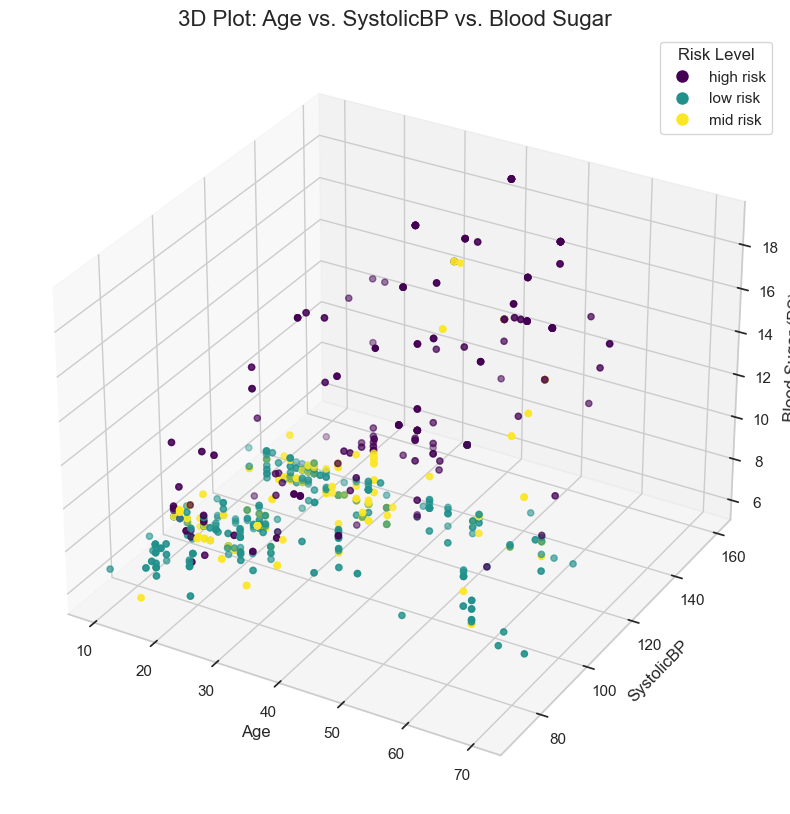

In [16]:
# --- 3D Scatter Plot: Age vs. SystolicBP vs. BS ---
# This plot will be interactive if your notebook environment supports it (like default Jupyter)
print("Generating 3D Scatter Plot...")
le_3d = LabelEncoder()
colors_3d = le_3d.fit_transform(df['RiskLevel'])

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df['Age'], 
    df['SystolicBP'], 
    df['BS'], 
    c=colors_3d, 
    cmap='viridis', 
    s=20
)

ax.set_title('3D Plot: Age vs. SystolicBP vs. Blood Sugar', fontsize=16)
ax.set_xlabel('Age')
ax.set_ylabel('SystolicBP')
ax.set_zlabel('Blood Sugar (BS)')
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=c,
                          markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10)
                   for i, c in enumerate(le_3d.classes_)]
ax.legend(handles=legend_elements, title='Risk Level')
plt.show()

In [17]:
# --- Train-Test Split ---
# Define X (features) and y (target)
X = df.drop('RiskLevel', axis=1)
y = df['RiskLevel']

# We use stratify=y because the dataset is imbalanced (see EDA 4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (811, 6)
X_test shape: (203, 6)
y_train shape: (811,)
y_test shape: (203,)


In [18]:
# --- Define Feature Types ---
# All features are numeric and continuous (or can be treated as such)
ALL_FEATURES = list(X.columns)

print(f"All {len(ALL_FEATURES)} features will be treated as numeric.")

# --- Create Preprocessing Pipeline ---
# Since all features are numeric, the pipeline is simple:
# 1. Impute missing values (just in case, using mean)
# 2. Scale all features (StandardScaler)

preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

print("Preprocessing pipeline (Imputer + StandardScaler) defined.")

All 6 features will be treated as numeric.
Preprocessing pipeline (Imputer + StandardScaler) defined.


In [19]:
# --- Apply the Preprocessing Pipeline ---

# Fit on training data and transform it
print("Fitting and transforming X_train...")
X_train_processed = preprocessor.fit_transform(X_train)

# Only transform the test data (using stats from training)
print("Transforming X_test...")
X_test_processed = preprocessor.transform(X_test)

# --- Label Encode Target ---
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
class_names = le.classes_

print(f"\nPreprocessing complete.")
print(f"Processed X_train shape: {X_train_processed.shape}")
print(f"Encoded y_train shape: {y_train_enc.shape}")
print(f"Target classes (encoded): {list(zip(le.classes_, np.unique(y_train_enc)))}")

Fitting and transforming X_train...
Transforming X_test...

Preprocessing complete.
Processed X_train shape: (811, 6)
Encoded y_train shape: (811,)
Target classes (encoded): [('high risk', 0), ('low risk', 1), ('mid risk', 2)]


In [38]:
# --- Define Model Pipeline (Better Accuracy Parameters) ---
print("Defining model pipeline... (Using parameters tuned for better accuracy)")

# Get the final number of features (e.g., 6 for Maternal set, 4 for Iris)
# This assumes X_train_processed exists from the previous cell
n_features_final = X_train_processed.shape[1]

# Models that are multi-class ready (or support it natively)
multi_class_models = {
    "KNN": KNN(k=5), # k=5 is a robust default
    "GNB": GaussianNaiveBayes(), # No major params
    "LDA": LDA(), # No major params
    "DT": DecisionTreeClassifier(max_depth=10, min_samples_split=5), # Your params are good
    "RF": RandomForestClassifier(
        n_trees=100,          # <-- BETTER (was 20). More trees = more stable/accurate
        max_depth=10, 
        min_samples_split=5
    ), 
}

# Binary models wrapped in OvR (needed for this multi-class problem)
binary_models_to_wrap = {
    "LogReg_OvR": (LogisticRegression, {
        "learning_rate": 0.01, 
        "n_iters": 2000,        # <-- BETTER (was 500). Allows for full convergence.
        "verbose": False
    }),
    "SVM_OvR": (LinearSVM, {
        "learning_rate": 0.001, 
        "lambda_param": 0.01, 
        "n_iters": 2000,        # <-- BETTER (was 500). Allows for full convergence.
        "verbose": False
    }),
    "MLP_OvR": (SimpleMLP, {
        "n_input": n_features_final, 
        "n_hidden": 16,         # <-- BETTER (was 8). More capacity for 6 features.
        "n_output": 1,
        "learning_rate": 0.01, 
        "n_iters": 2000,        # <-- BETTER (was 500). Allows for full convergence.
        "verbose": False, 
        "activation": 'relu'
    }),
    "AdaBoost_OvR": (AdaBoost, {
        "n_estimators": 50      # <-- BETTER (was 20). Matches sklearn default.
    }),
}

# --- Combine the dictionaries ---
all_models = multi_class_models.copy()
for name, (model_class, kwargs) in binary_models_to_wrap.items():
    all_models[name] = OvRWrapper(model_class, **kwargs)
    
print(f"Total models to train: {len(all_models)}")
print("Models to run:", list(all_models.keys()))

Defining model pipeline... (Using parameters tuned for better accuracy)
Total models to train: 9
Models to run: ['KNN', 'GNB', 'LDA', 'DT', 'RF', 'LogReg_OvR', 'SVM_OvR', 'MLP_OvR', 'AdaBoost_OvR']


In [39]:
# --- Run All Models ---
results = {}
reports = {}
models_trained = {} # To store the trained model instances

print("\n--- Running Model Benchmarks on Processed Data ---")

# Wrap the model loop with tqdm for a progress bar
for name, model in tqdm(all_models.items(), desc="Overall Model Progress"):
    try:
        # print(f"\n--- Training {name} ---") # Removed for cleaner tqdm output
        start_time = time.time()
        
        # Train the model
        model.fit(X_train_processed, y_train_enc)
        
        # print(f"  Predicting with {name}...")
        y_pred = model.predict(X_test_processed)
        
        duration = time.time() - start_time
        acc = accuracy_score(y_test_enc, y_pred)
        # Generate report as a dictionary for later use
        report_dict = classification_report(y_test_enc, y_pred, target_names=class_names, output_dict=True, zero_division=0)
        
        results[name] = acc
        reports[name] = report_dict
        models_trained[name] = model # Save the trained model
        
        # print(f"  ✅ {name} Accuracy: {acc:<8.4f} (Time: {duration:.2f}s)")
    
    except Exception as e:
        import traceback
        print(f"  ❌ ERROR training/predicting with {name}: {e}")
        traceback.print_exc() 
        results[name] = 0.0
        reports[name] = str(e)

print("\nAll models trained and evaluated.")


--- Running Model Benchmarks on Processed Data ---


Overall Model Progress:   0%|          | 0/9 [00:00<?, ?it/s]

KNN fitted with 811 samples.
Predicting for 203 samples using KNN (k=5)...
Fitting Gaussian Naive Bayes...
Fitting complete.
Predicting labels for 203 samples using GNB...
Fitting LDA...
LDA fitting complete.
Predicting labels for 203 samples using LDA...
Fitting Decision Tree: max_depth=10, min_split=5, features_per_split=6...
Tree fitting complete.
Predicting labels for 203 samples using Decision Tree...
Fitting Random Forest: 100 trees, max_depth=10, min_split=5, features_per_split=2...
  Tree 10/100 fitted.
  Tree 20/100 fitted.
  Tree 30/100 fitted.
  Tree 40/100 fitted.
  Tree 50/100 fitted.
  Tree 60/100 fitted.
  Tree 70/100 fitted.
  Tree 80/100 fitted.
  Tree 90/100 fitted.
  Tree 100/100 fitted.
Random Forest fitting complete.
Predicting labels for 203 samples using Random Forest (100 trees)...
Starting Logistic Regression training for up to 2000 iterations...
Convergence reached at iteration 637. Cost = 0.390639
Starting Logistic Regression training for up to 2000 iteration

In [40]:
# --- Final Results Summary ---

print("\n\n" + "="*30)
print("🏁 FINAL ACCURACY SUMMARY 🏁")
print("="*30 + "\n")

# Convert results to a DataFrame for easy sorting
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])
results_df = results_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# Format accuracy as percentage
results_df['Accuracy'] = results_df['Accuracy'].apply(lambda x: f"{x*100:.2f}%")

print(results_df.to_string())



🏁 FINAL ACCURACY SUMMARY 🏁

          Model Accuracy
0            RF   80.79%
1            DT   76.35%
2  AdaBoost_OvR   67.98%
3           KNN   67.49%
4       MLP_OvR   63.55%
5    LogReg_OvR   62.56%
6           LDA   62.07%
7           GNB   61.58%
8       SVM_OvR   60.59%


In [41]:
# --- Best Model Classification Report ---

# Get the name and accuracy of the best model (re-sorting by number)
best_model_name = sorted(results.items(), key=lambda item: item[1], reverse=True)[0][0]
best_accuracy = results[best_model_name]

print(f"\n\n--- 🏆 Best Model ---")
print(f"{best_model_name} (Accuracy: {best_accuracy*100:.2f}%)")

# --- Print Classification Report for the Best Model ---
print("\n--- Classification Report for Best Model ---")
best_report_dict = reports[best_model_name]
if isinstance(best_report_dict, dict):
    best_report_df = pd.DataFrame(best_report_dict).transpose()
    print(best_report_df)
else:
    print(best_report_dict) # Print error message if it failed



--- 🏆 Best Model ---
RF (Accuracy: 80.79%)

--- Classification Report for Best Model ---
              precision    recall  f1-score     support
high risk      0.961538  0.909091  0.934579   55.000000
low risk       0.764045  0.839506  0.800000   81.000000
mid risk       0.741935  0.686567  0.713178   67.000000
accuracy       0.807882  0.807882  0.807882    0.807882
macro avg      0.822506  0.811721  0.815919  203.000000
weighted avg   0.810256  0.807882  0.807807  203.000000


Predicting labels for 203 samples using Random Forest (100 trees)...


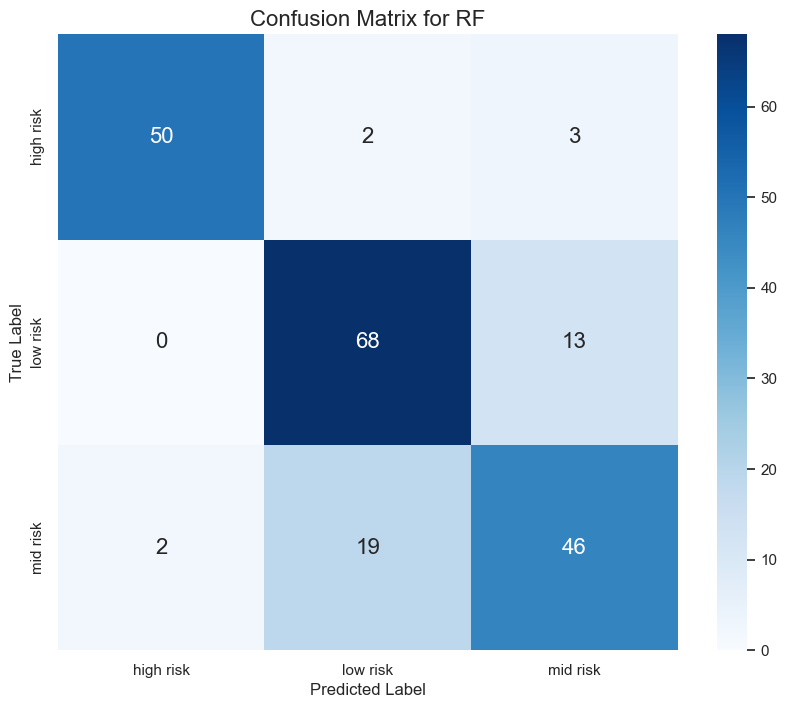

In [42]:
# --- Confusion Matrix for Best Model ---

# Get the trained model instance
best_model_instance = models_trained[best_model_name]
y_pred_best = best_model_instance.predict(X_test_processed)

cm = confusion_matrix(y_test_enc, y_pred_best)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            annot_kws={"size": 16})
plt.title(f'Confusion Matrix for {best_model_name}', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()